# Лабараторная работа №1
### Выполнил Росляков Владислав Александрович
### Студент группы ББМО-01-23

Копируем проект

In [ ]:
!git clone https://github.com/ewatson2/EEL6812_DeepFool_Project.git

Cloning into 'EEL6812_DeepFool_Project'...
remote: Enumerating objects: 96, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 96 (delta 2), reused 1 (delta 1), pack-reused 93 (from 1)
Receiving objects: 100% (96/96), 33.99 MiB | 15.17 MiB/s, done.
Resolving deltas: 100% (27/27), done.


Меняем директорию

In [ ]:

cd /content/EEL6812_DeepFool_Project

/content/EEL6812_DeepFool_Project


Импортируем библиотеки

In [ ]:
import numpy as np
import json, torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models
from torchvision.transforms import transforms
from models.project_models import FC_500_150, LeNet_CIFAR, LeNet_MNIST, Net
from utils.project_utils import get_clip_bounds, evaluate_attack, display_attack

In [ ]:
rand_seed = 22

In [ ]:
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

Загружаем датасет MNIST c параметрами mnist_mean = 0.5, mnist_std = 0.5, mnist_dim = 28

In [ ]:
mnist_mean = 0.5
mnist_std = 0.5
mnist_dim = 28

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

mnist_min, mnist_max = get_clip_bounds(mnist_mean, mnist_std, mnist_dim)
mnist_min = mnist_min.to(device)
mnist_max = mnist_max.to(device)
mnist_tf = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=mnist_mean, std=mnist_std)])
mnist_tf_train = transforms.Compose([ transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize( mean=mnist_mean, std=mnist_std)])
mnist_tf_inv = transforms.Compose([ transforms.Normalize( mean=0.0, std=np.divide(1.0, mnist_std)), transforms.Normalize( mean=np.multiply(-1.0, mnist_std), std=1.0)])
mnist_temp = datasets.MNIST(root='datasets/mnist', train=True, download=True, transform=mnist_tf_train)
mnist_train, mnist_val = random_split(mnist_temp, [50000, 10000])
mnist_test = datasets.MNIST(root='datasets/mnist', train=False, download=True, transform=mnist_tf)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.13MB/s]


Extracting datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.98MB/s]

Extracting datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/mnist/MNIST/raw



Загружаем датасет CIFAR-10 c параметрами cifar_mean = [0.491, 0.482, 0.447] cifar_std = [0.202, 0.199, 0.201] cifar_dim = 32

In [ ]:
cifar_mean = [0.491, 0.482, 0.447]
cifar_std = [0.202, 0.199, 0.201]
cifar_dim = 32

cifar_min, cifar_max = get_clip_bounds(cifar_mean, cifar_std, cifar_dim)
cifar_min = cifar_min.to(device)
cifar_max = cifar_max.to(device)
cifar_tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])
cifar_tf_train = transforms.Compose([transforms.RandomCrop(size=cifar_dim, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=cifar_mean, std=cifar_std)])
cifar_tf_inv = transforms.Compose([transforms.Normalize(mean=[0.0, 0.0, 0.0], std=np.divide(1.0, cifar_std)), transforms.Normalize(mean=np.multiply(-1.0, cifar_mean), std=[1.0, 1.0, 1.0])])
cifar_temp = datasets.CIFAR10(root='datasets/cifar-10', train=True, download=True, transform=cifar_tf_train)
cifar_train, cifar_val = random_split(cifar_temp, [40000, 10000])
cifar_test = datasets.CIFAR10(root='datasets/cifar-10', train=False, download=True, transform=cifar_tf)
cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting datasets/cifar-10/cifar-10-python.tar.gz to datasets/cifar-10
Files already downloaded and verified


Настройка и загрузка DataLoader

In [ ]:
batch_size = 64
workers = 4

mnist_loader_train = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=workers)
mnist_loader_val = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=workers)
mnist_loader_test = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_train = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=workers)
cifar_loader_val = DataLoader(cifar_val, batch_size=batch_size, shuffle=False, num_workers=workers)
cifar_loader_test = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Загрузим и оценим стойкость модели Network-In-Network Model к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [ ]:
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_nin_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')

deep_args = [10, 10, 0.02, 50] # Задаём гиперпараметры DeepFool
evaluate_attack('cifar_nin_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()
print('')

FGSM Test Error : 81.29%
FGSM Robustness : 1.77e-01
FGSM Time (All Images) : 0.67 s
FGSM Time (Per Image) : 67.07 us

DeepFool Test Error : 93.76%
DeepFool Robustness : 2.12e-02
DeepFool Time (All Images) : 185.12 s
DeepFool Time (Per Image) : 18.51 ms



<ipython-input-9-3b8c6d17234d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth', map_location=torch.device('cp

Загрузим и оценим стойкость модели LeNet к FGSM и DeepFool атакам на основе датасета CIFAR-10

In [ ]:
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device('cpu')))
evaluate_attack('cifar_lenet_fgsm.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, fgsm_eps, is_fgsm=True)
print('')
evaluate_attack('cifar_lenet_deepfool.csv', 'results', device, model, cifar_loader_test, cifar_min, cifar_max, deep_args, is_fgsm=False)
if device.type == 'cuda': torch.cuda.empty_cache()

FGSM Test Error : 91.71%
FGSM Robustness : 8.90e-02
FGSM Time (All Images) : 0.40 s
FGSM Time (Per Image) : 40.08 us

DeepFool Test Error : 87.81%
DeepFool Robustness : 1.78e-02
DeepFool Time (All Images) : 73.27 s
DeepFool Time (Per Image) : 7.33 ms


<ipython-input-10-d704bbba505a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth', map_location=torch.device(

Выполним оценку атакующих примеров для сетей.

<ipython-input-11-1d1353620f20>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

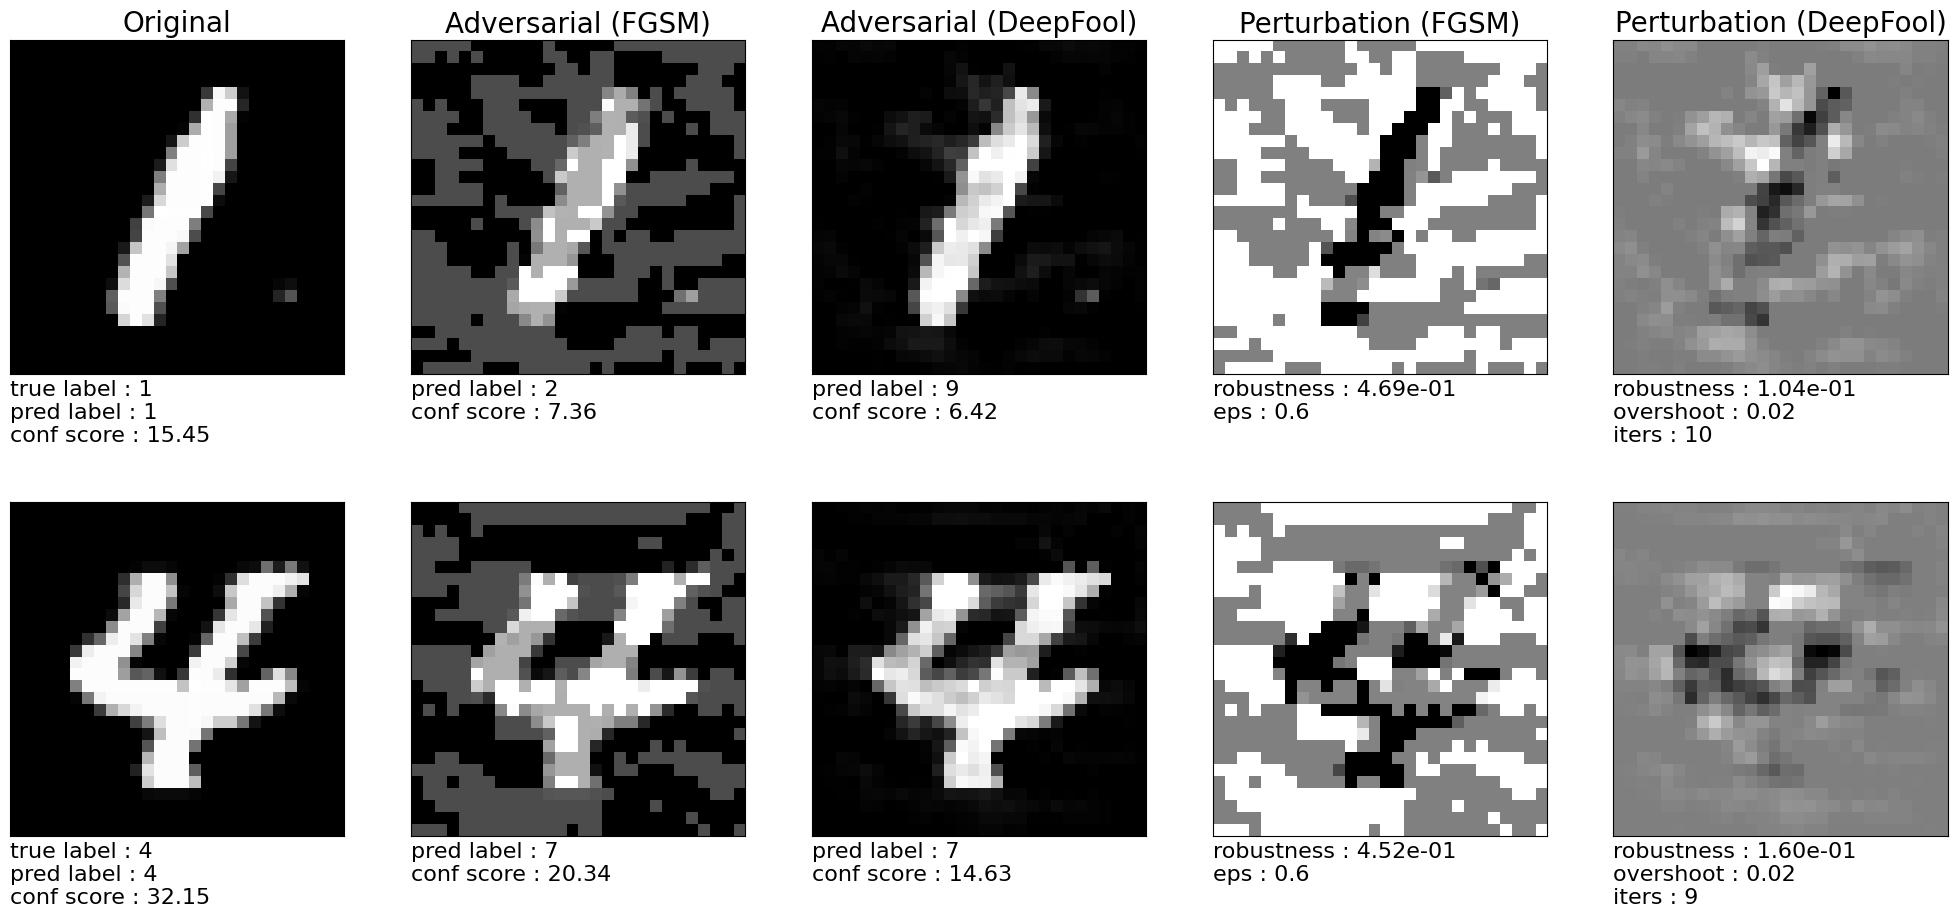

<ipython-input-11-1d1353620f20>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))


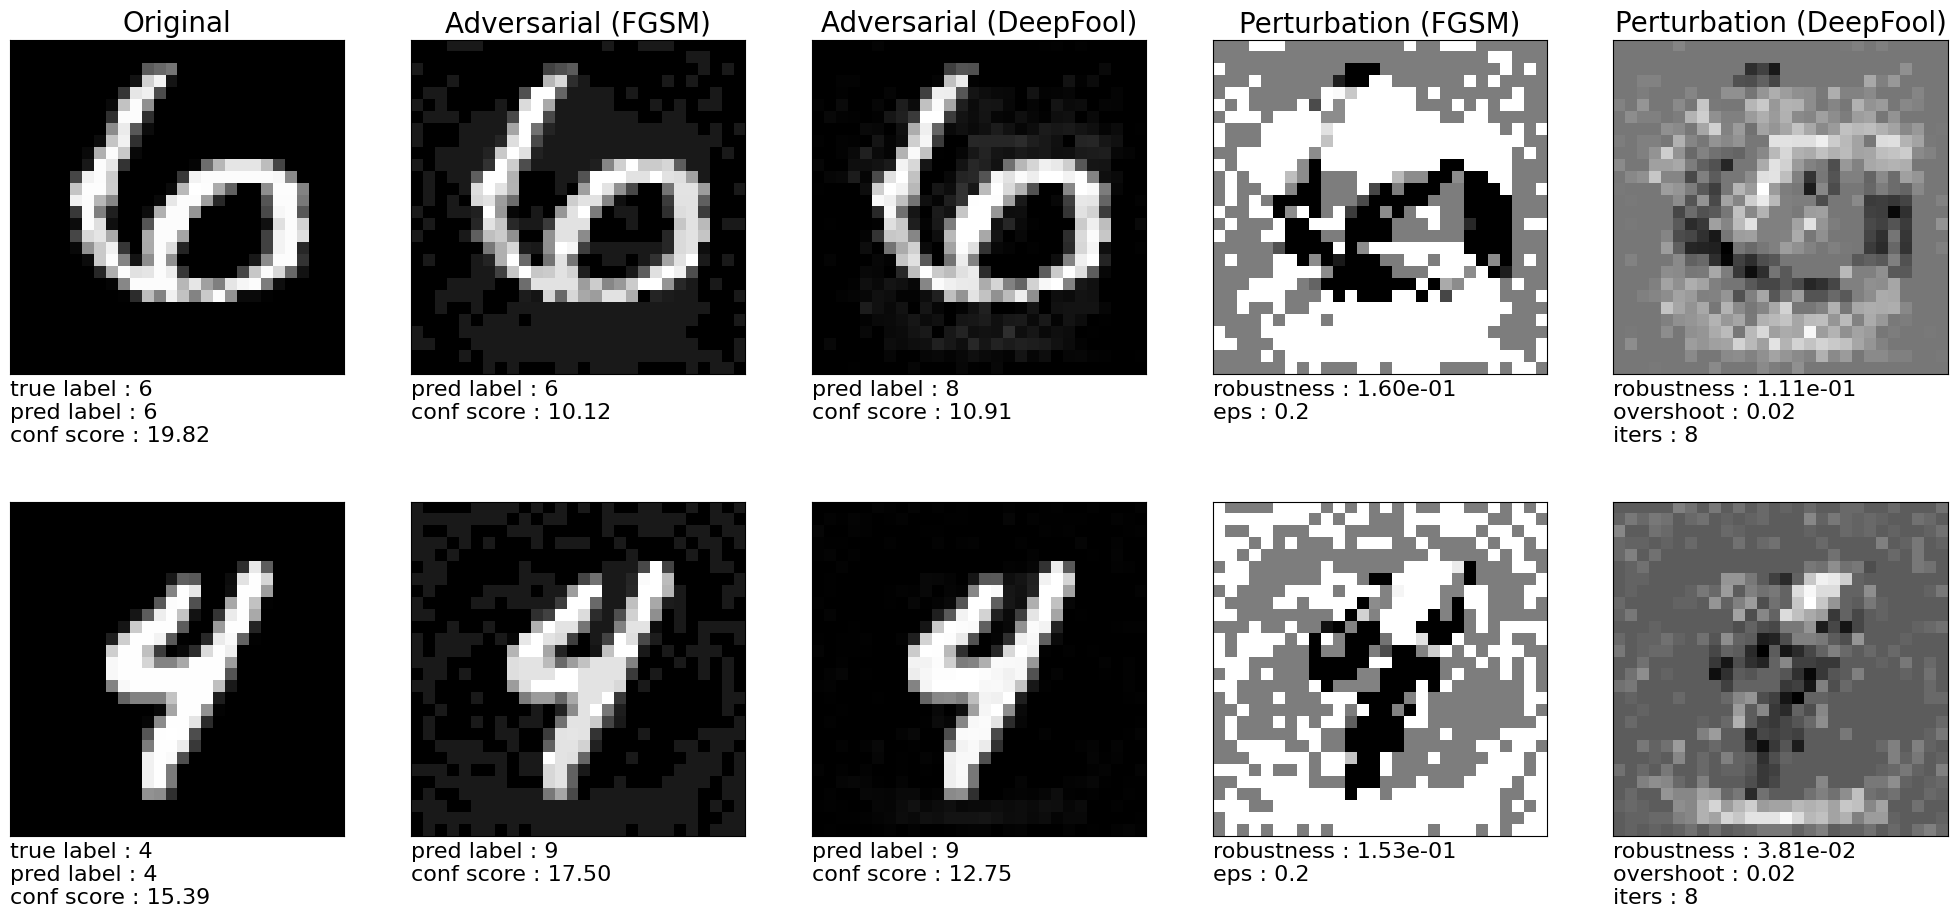

<ipython-input-11-1d1353620f20>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))


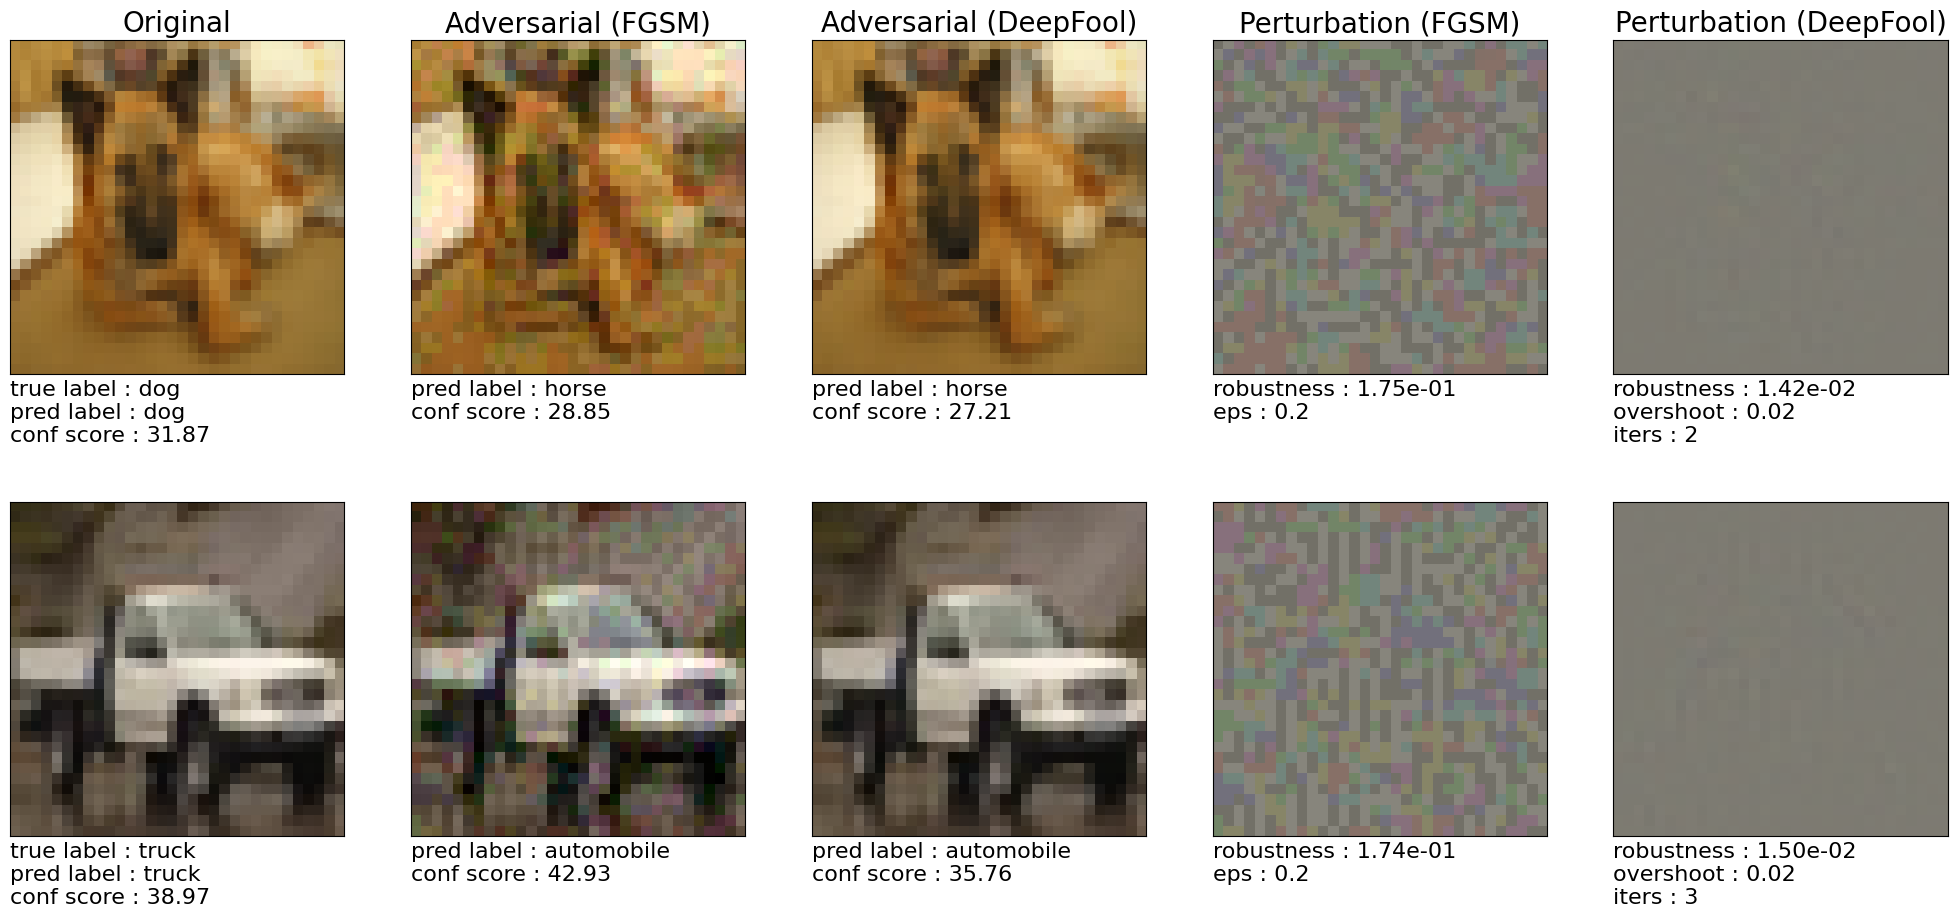

<ipython-input-11-1d1353620f20>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))


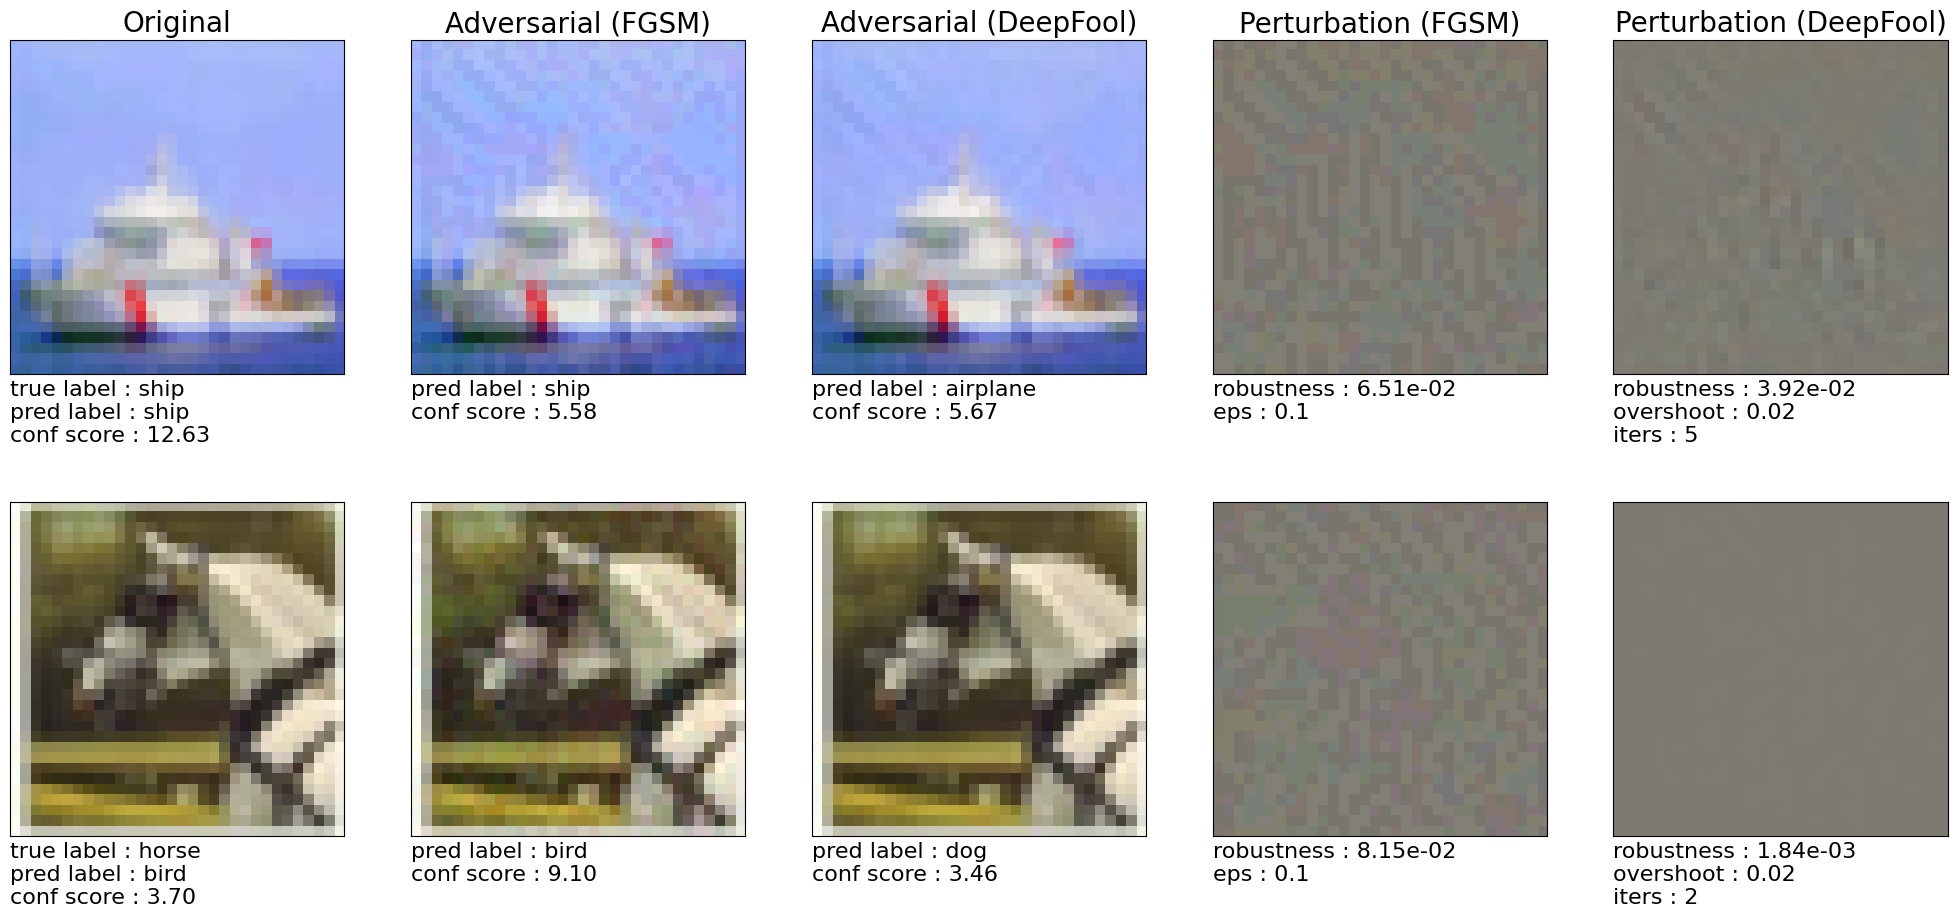

In [ ]:
#LeNet
fgsm_eps = 0.6
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()
#FCNet
fgsm_eps = 0.2
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
if device.type == 'cuda': torch.cuda.empty_cache()
#Network-in-Network
fgsm_eps = 0.2
model = Net().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_nin.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()
#LeNet CIFAR-10
fgsm_eps = 0.1
model = LeNet_CIFAR().to(device)
model.load_state_dict(torch.load('weights/clean/cifar_lenet.pth'))
display_attack(device, model, cifar_test, cifar_tf_inv, cifar_min, cifar_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11, label_map=cifar_classes)
if device.type == 'cuda': torch.cuda.empty_cache()

Отражаем отличия для fgsm_eps=(0.001, 0.02, 0.5, 0.9, 10) и выявить закономерность/обнаружить отсутсвие влияние параметра eps для сетей FC LeNet на датасете MNIST, NiN LeNEt на датасете CIFAR

Величина fsgsm_eps = 0.001:


<ipython-input-12-f40c437abc58>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))
/usr/local/lib/python3.10

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 1.69%
FGSM Robustness : 8.06e-04
FGSM Time (All Images) : 1.27 s
FGSM Time (Per Image) : 126.91 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


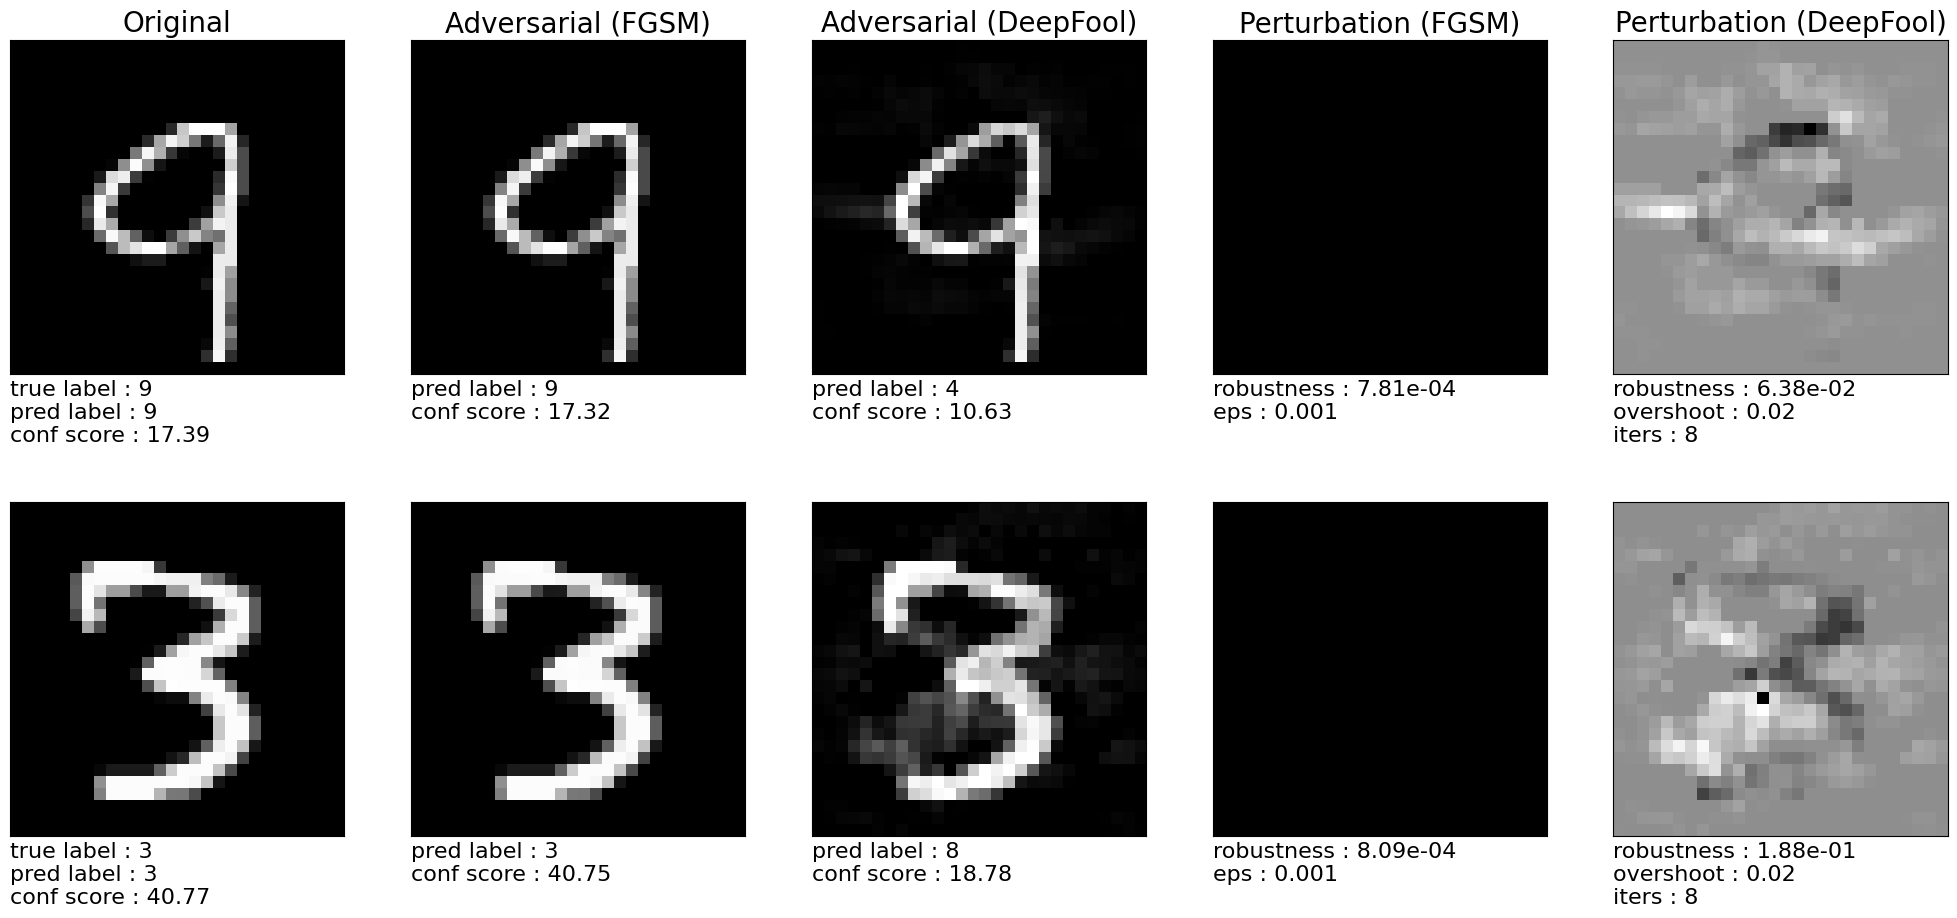


Величина fsgsm_eps = 0.02:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 2.56%
FGSM Robustness : 1.59e-02
FGSM Time (All Images) : 0.88 s
FGSM Time (Per Image) : 88.30 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


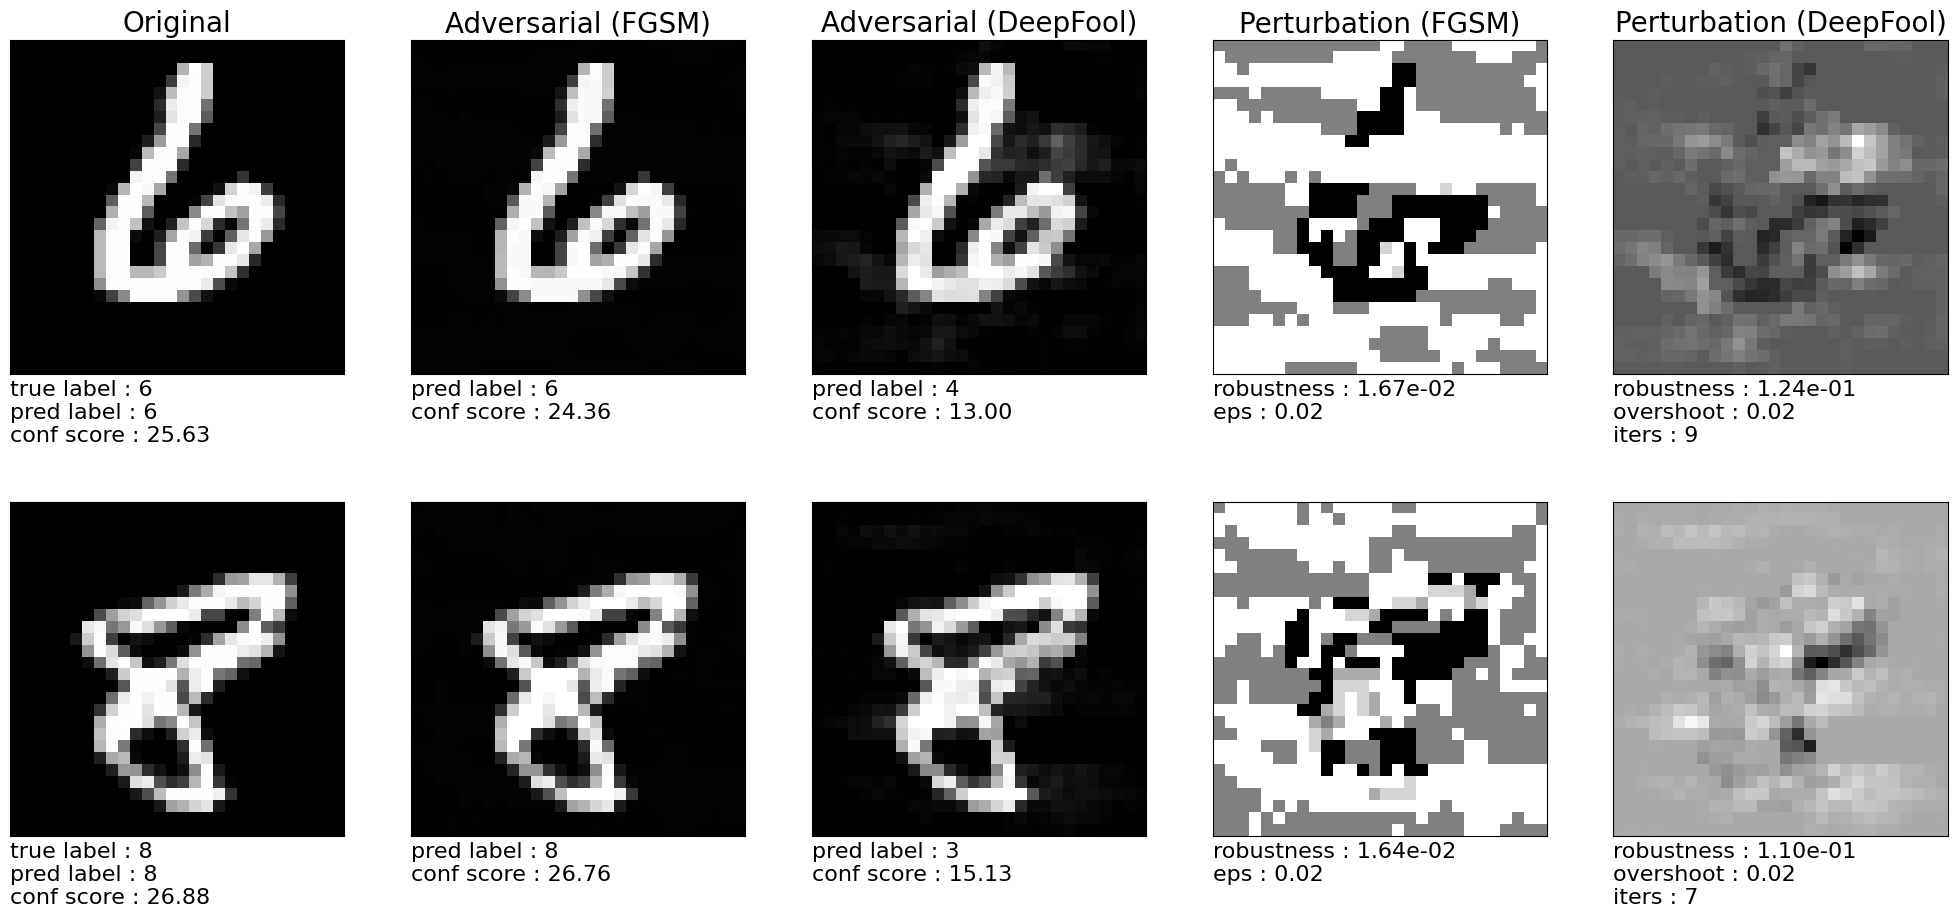


Величина fsgsm_eps = 0.5:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 82.92%
FGSM Robustness : 3.83e-01
FGSM Time (All Images) : 0.94 s
FGSM Time (Per Image) : 93.85 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


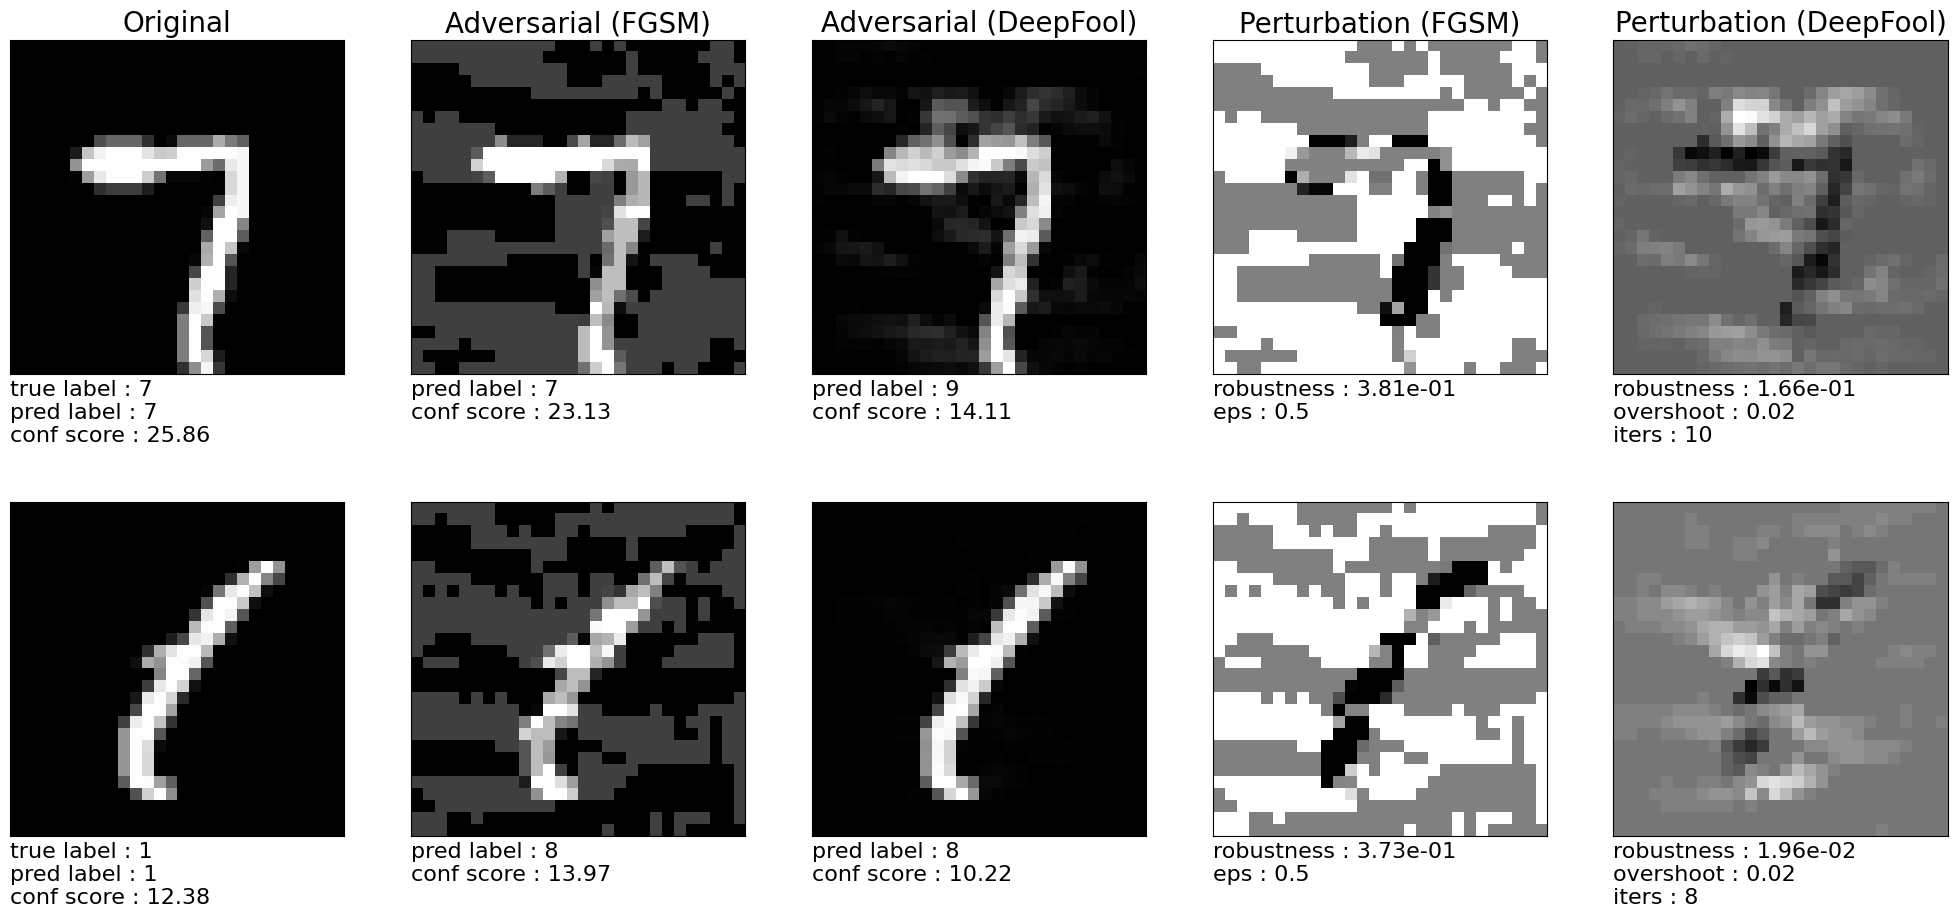


Величина fsgsm_eps = 0.9:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 93.80%
FGSM Robustness : 6.81e-01
FGSM Time (All Images) : 1.06 s
FGSM Time (Per Image) : 105.66 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


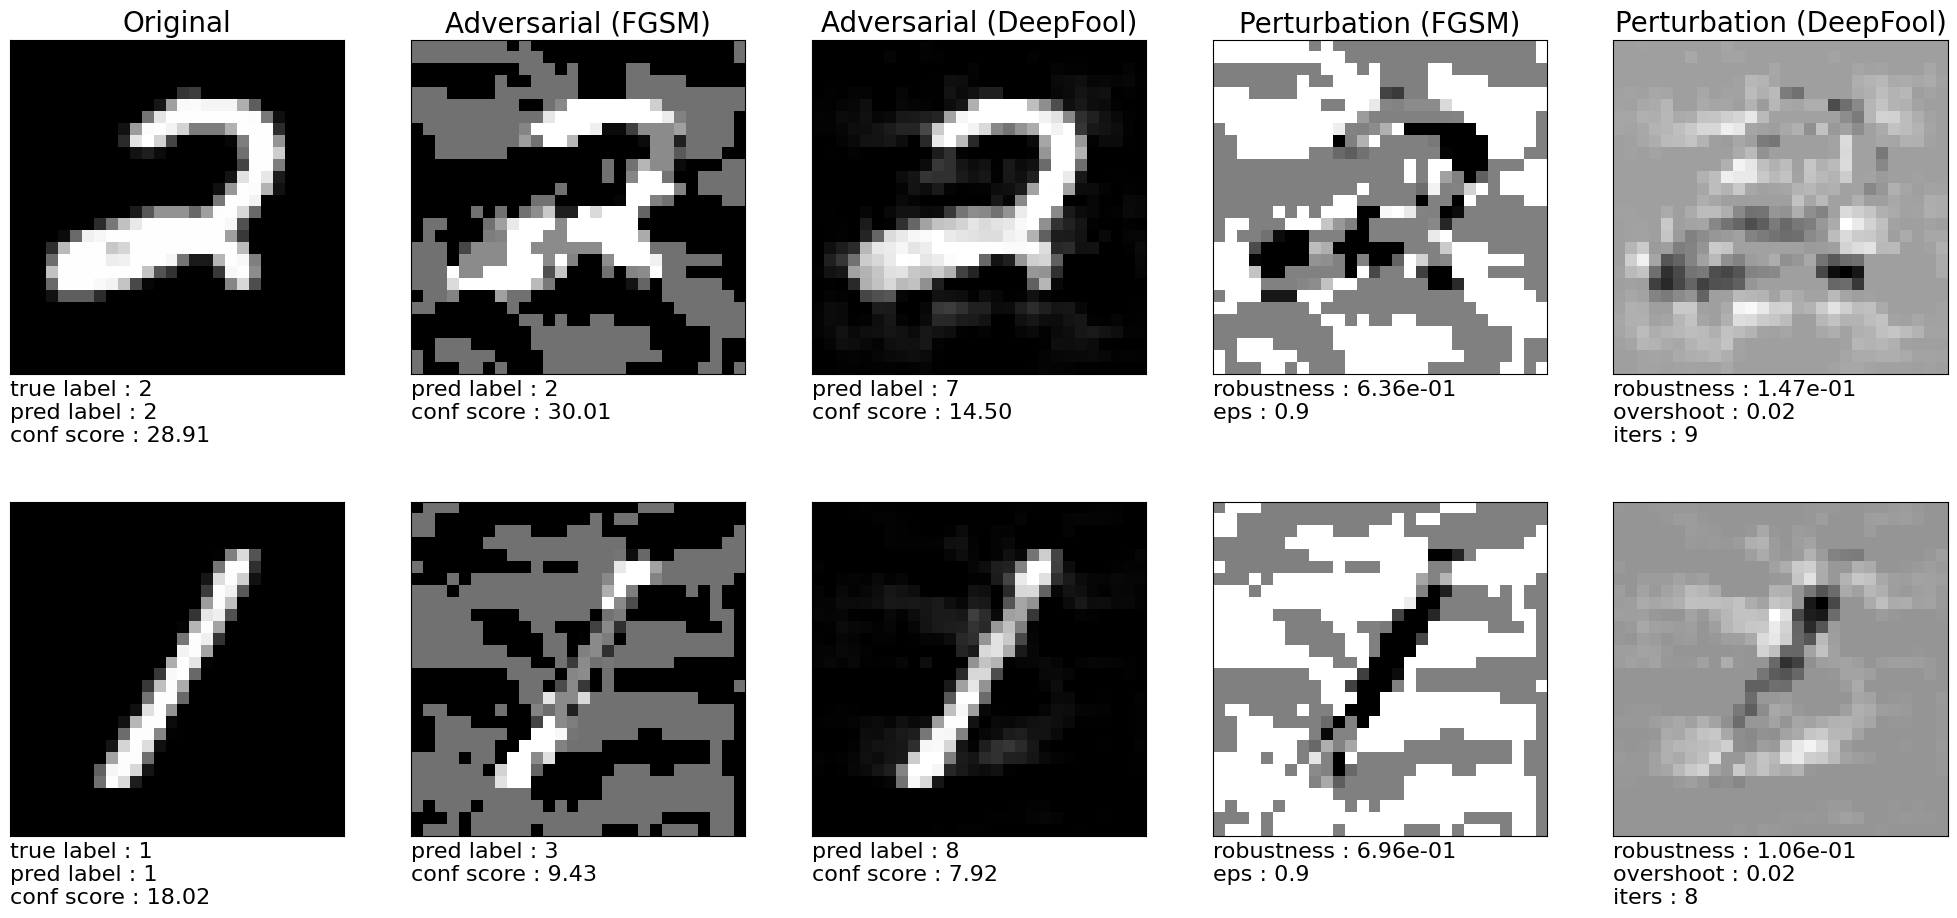


Величина fsgsm_eps = 10:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 94.15%
FGSM Robustness : 1.46e+00
FGSM Time (All Images) : 1.15 s
FGSM Time (Per Image) : 115.39 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


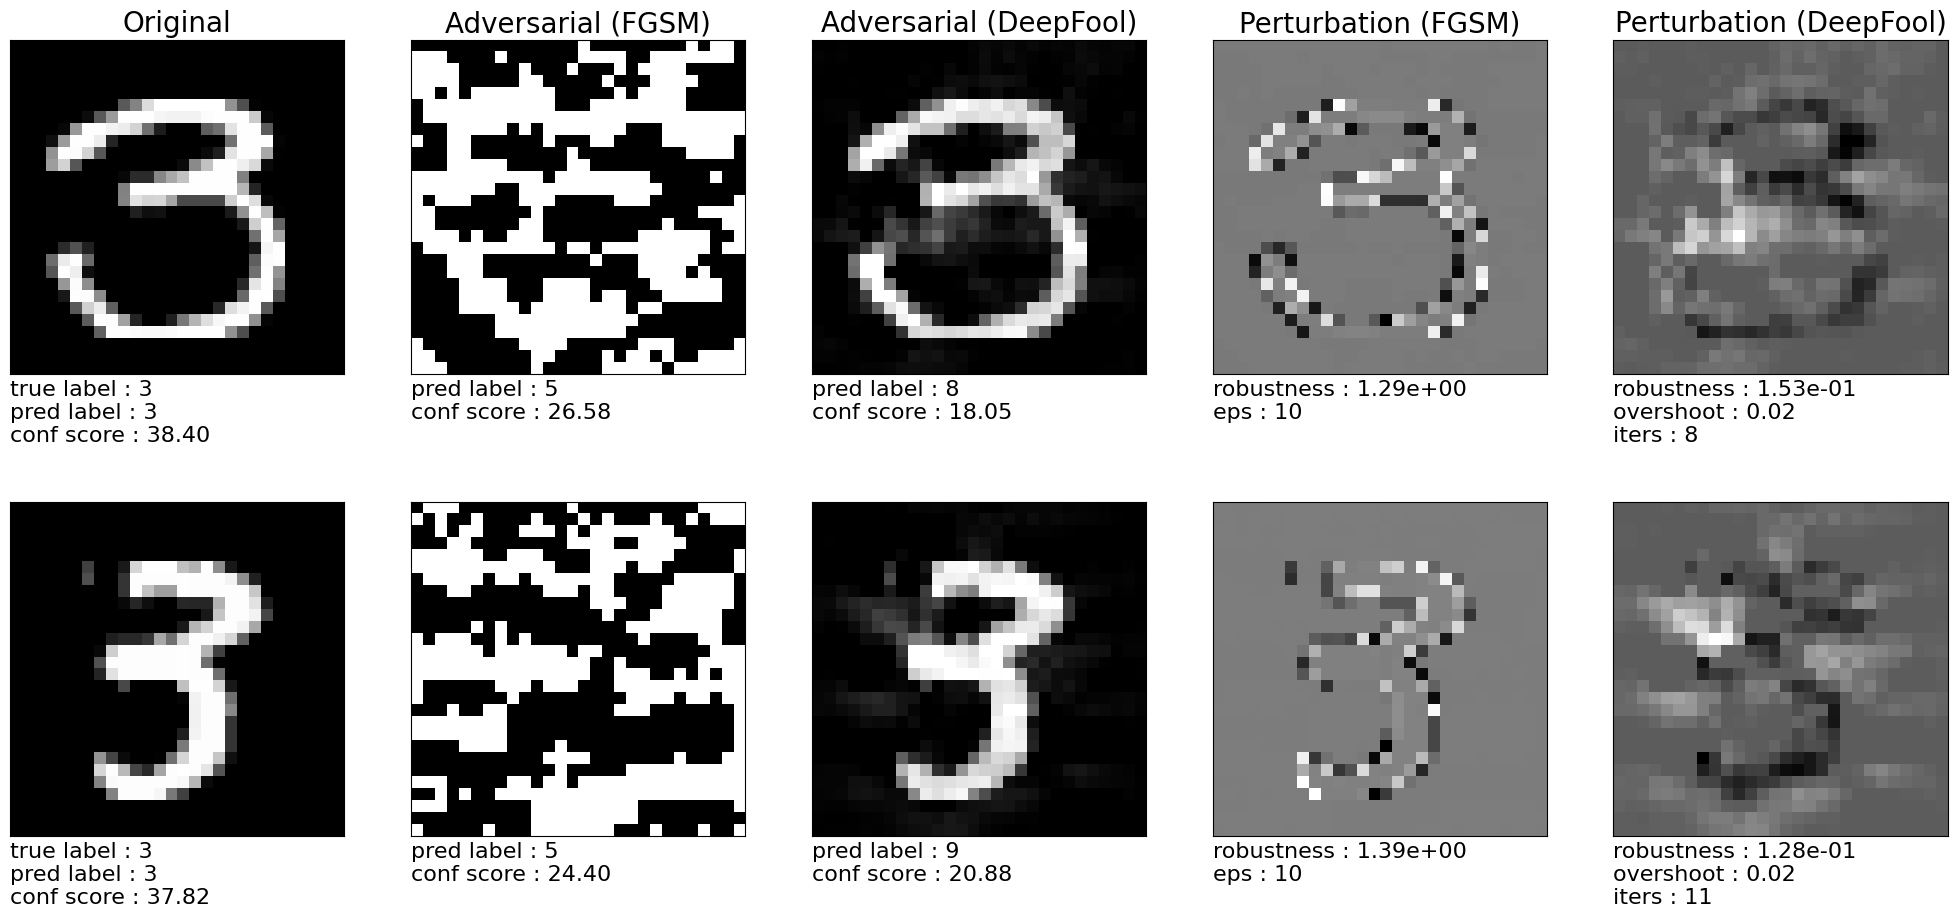

In [ ]:
#LeNet
model = LeNet_MNIST().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_lenet.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print(f"Величина fsgsm_eps = {fgsm_eps}:")
  mnist_lenet_fgsm = 'mnist_lenet_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(mnist_lenet_fgsm, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print('')

Величина fsgsm_eps = 0.001:


<ipython-input-13-cccd5e2d3d57>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))
/usr/local/lib/python3.10/di

FGSM Batches Complete : (157 / 157)
FGSM Test Error : 3.07%
FGSM Robustness : 8.08e-04
FGSM Time (All Images) : 0.49 s
FGSM Time (Per Image) : 49.25 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


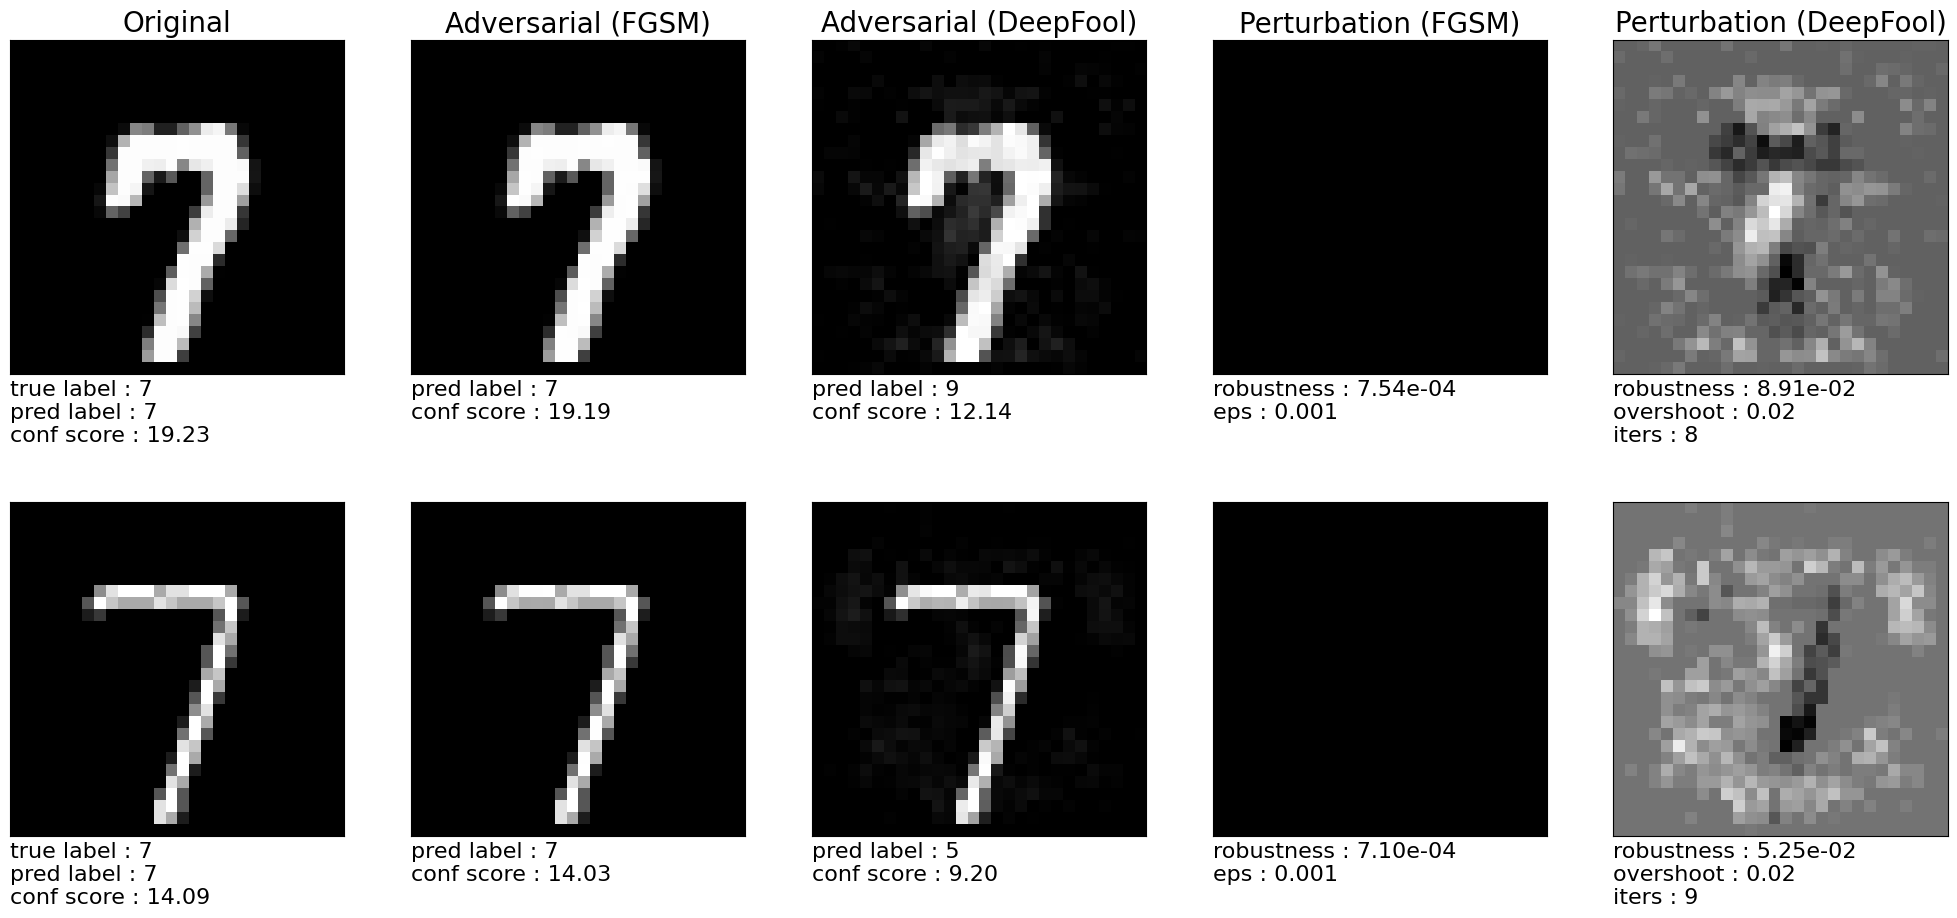


Величина fsgsm_eps = 0.02:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 5.54%
FGSM Robustness : 1.60e-02
FGSM Time (All Images) : 0.58 s
FGSM Time (Per Image) : 58.14 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


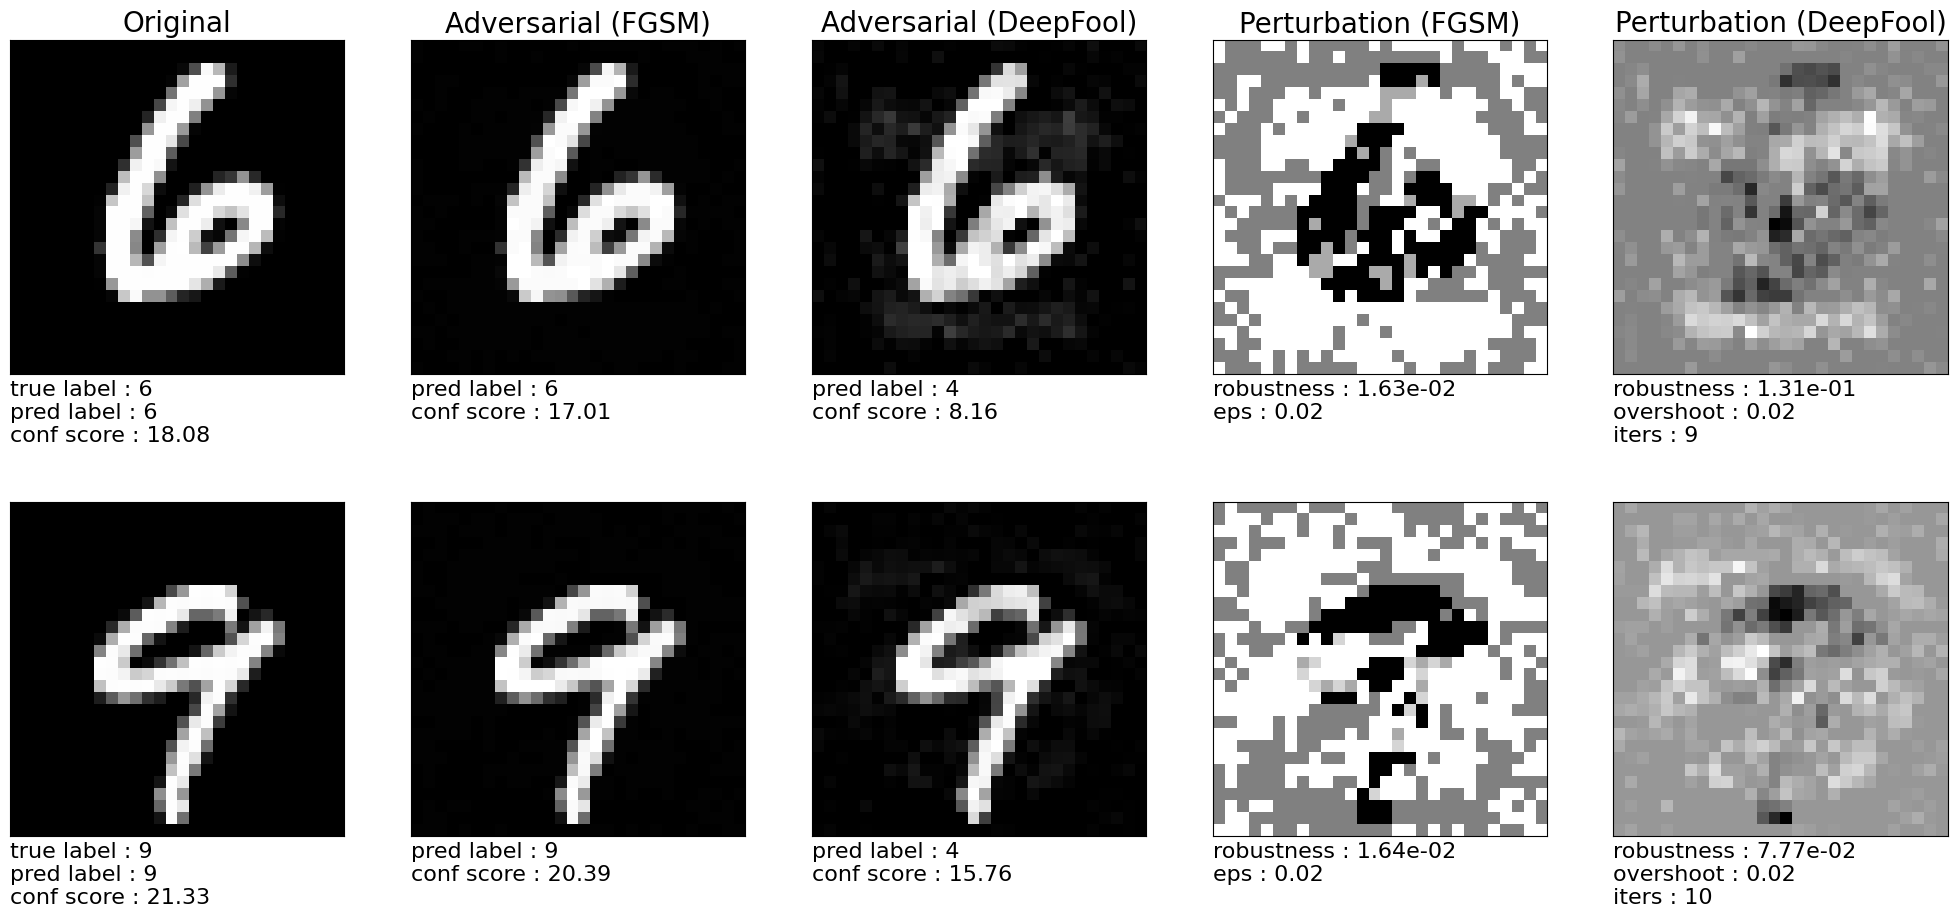


Величина fsgsm_eps = 0.5:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.21%
FGSM Robustness : 3.86e-01
FGSM Time (All Images) : 0.74 s
FGSM Time (Per Image) : 74.49 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


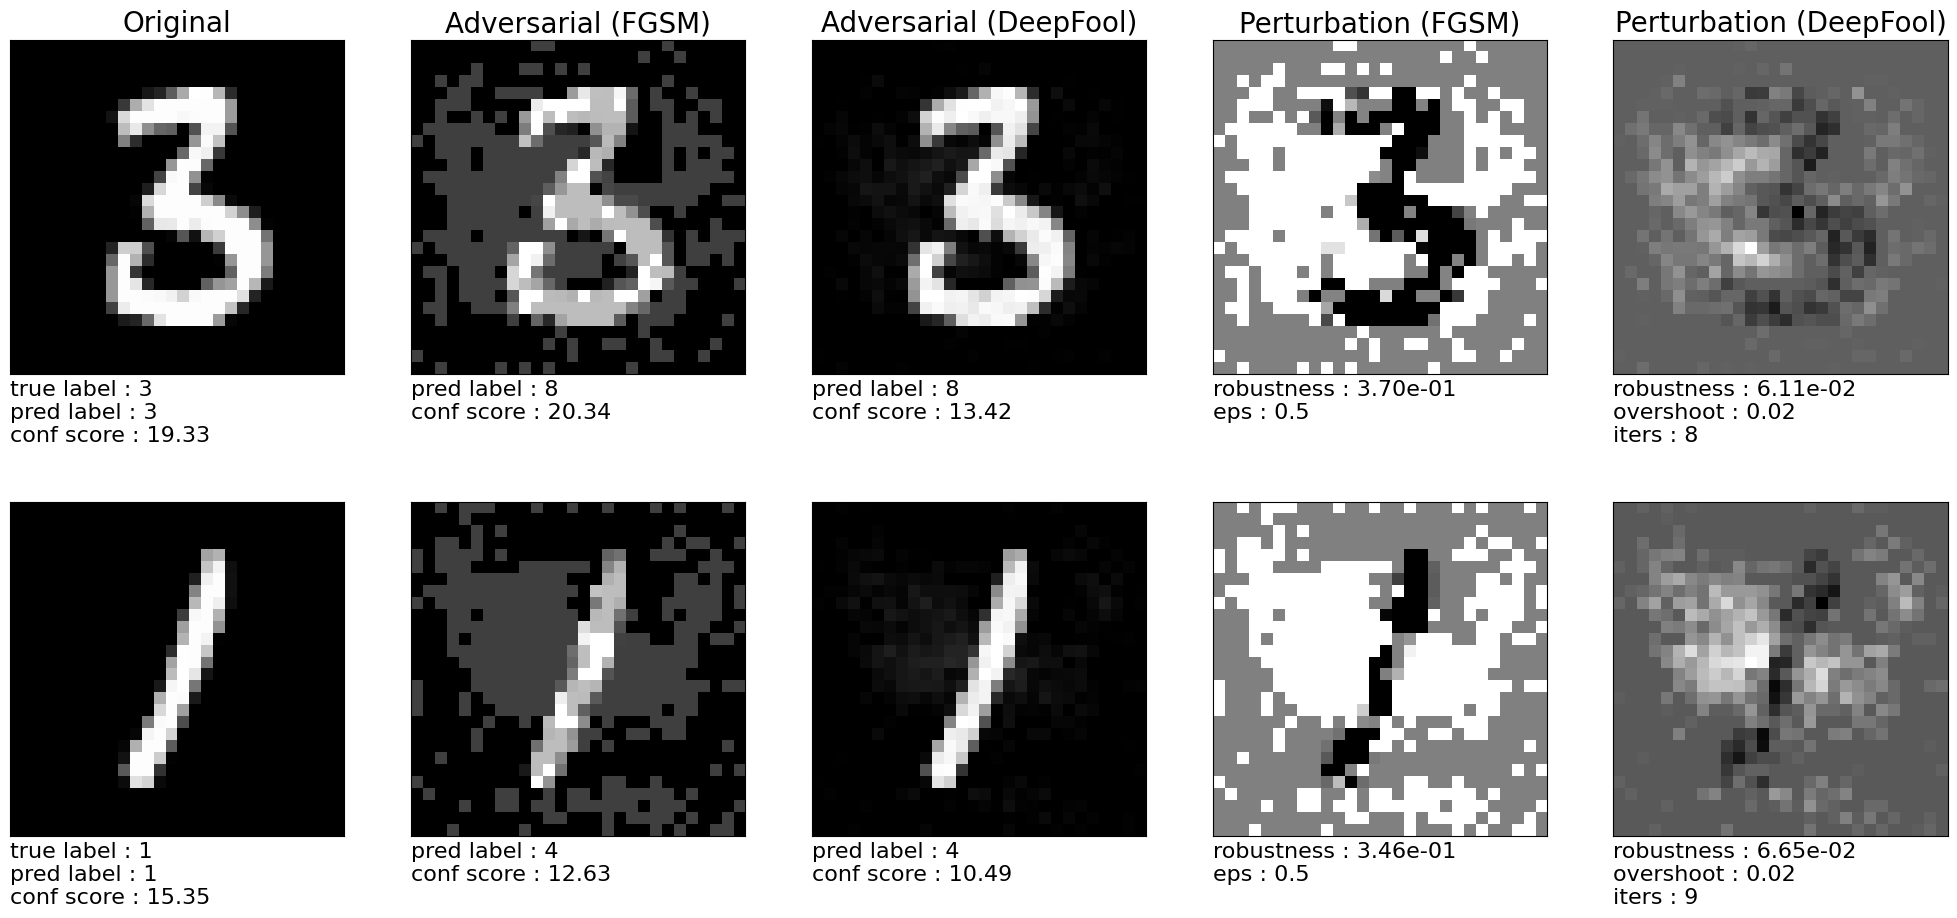


Величина fsgsm_eps = 0.9:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 6.86e-01
FGSM Time (All Images) : 0.50 s
FGSM Time (Per Image) : 50.46 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


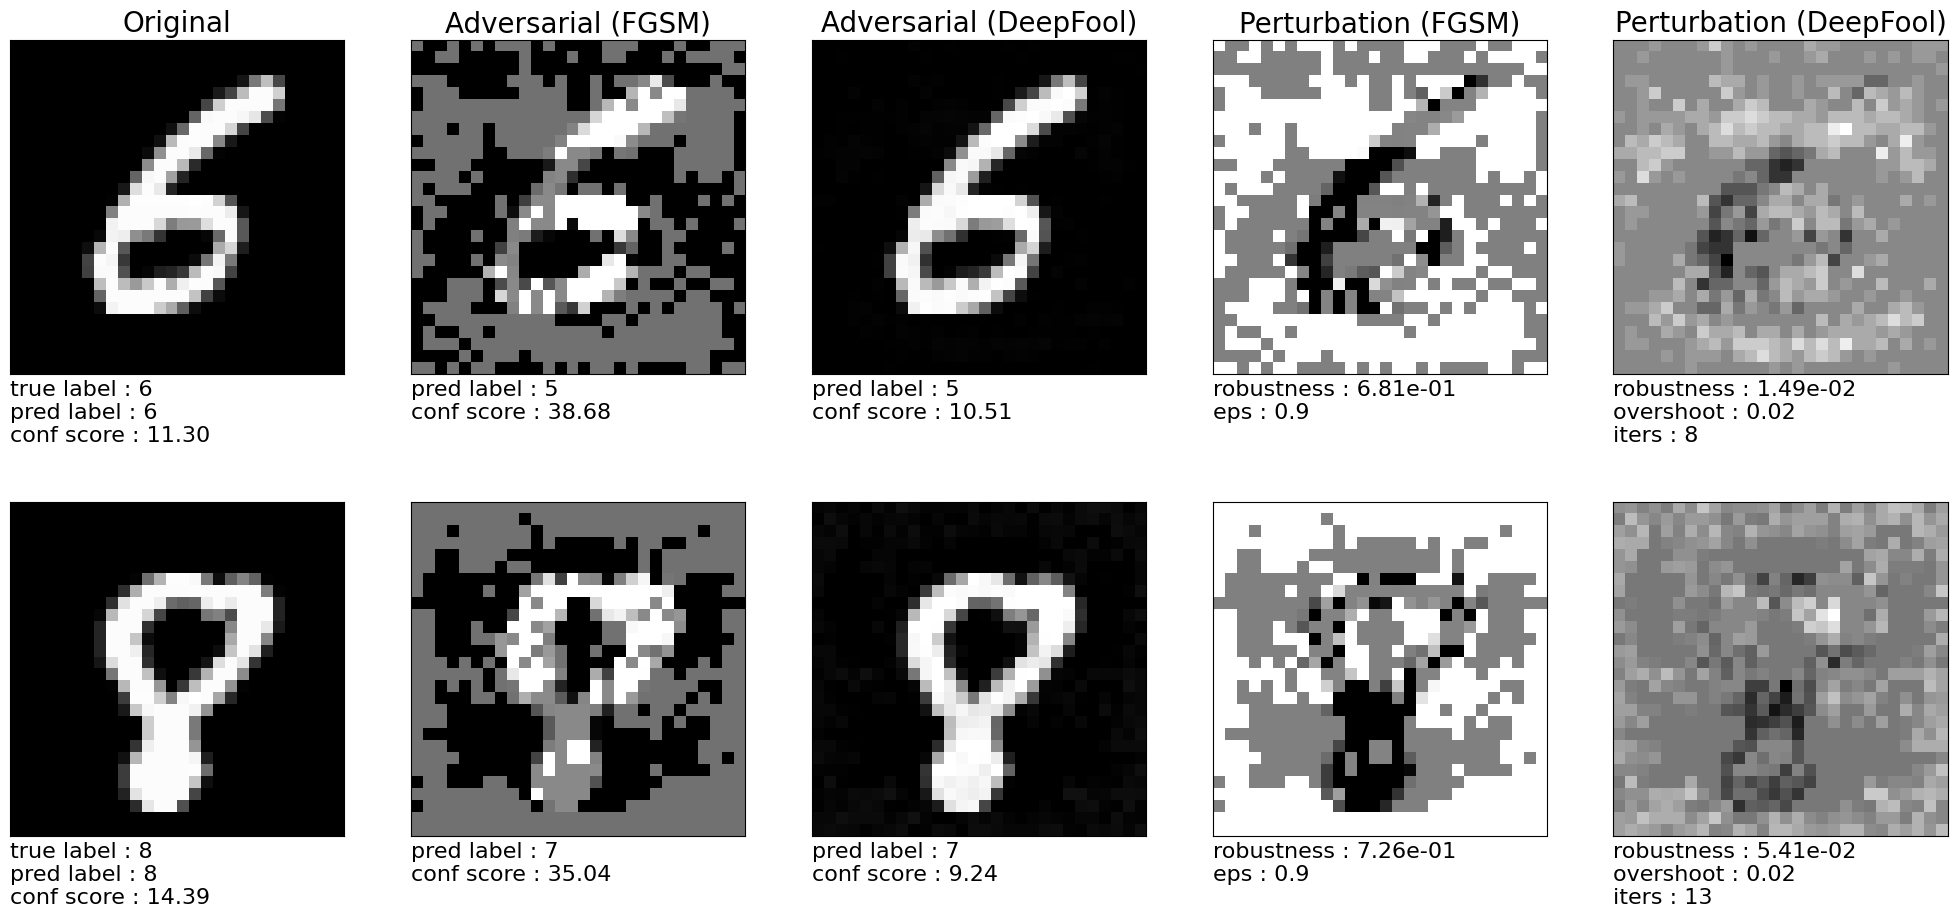


Величина fsgsm_eps = 10:


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


FGSM Batches Complete : (157 / 157)
FGSM Test Error : 99.87%
FGSM Robustness : 1.47e+00
FGSM Time (All Images) : 0.52 s
FGSM Time (Per Image) : 51.61 us


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


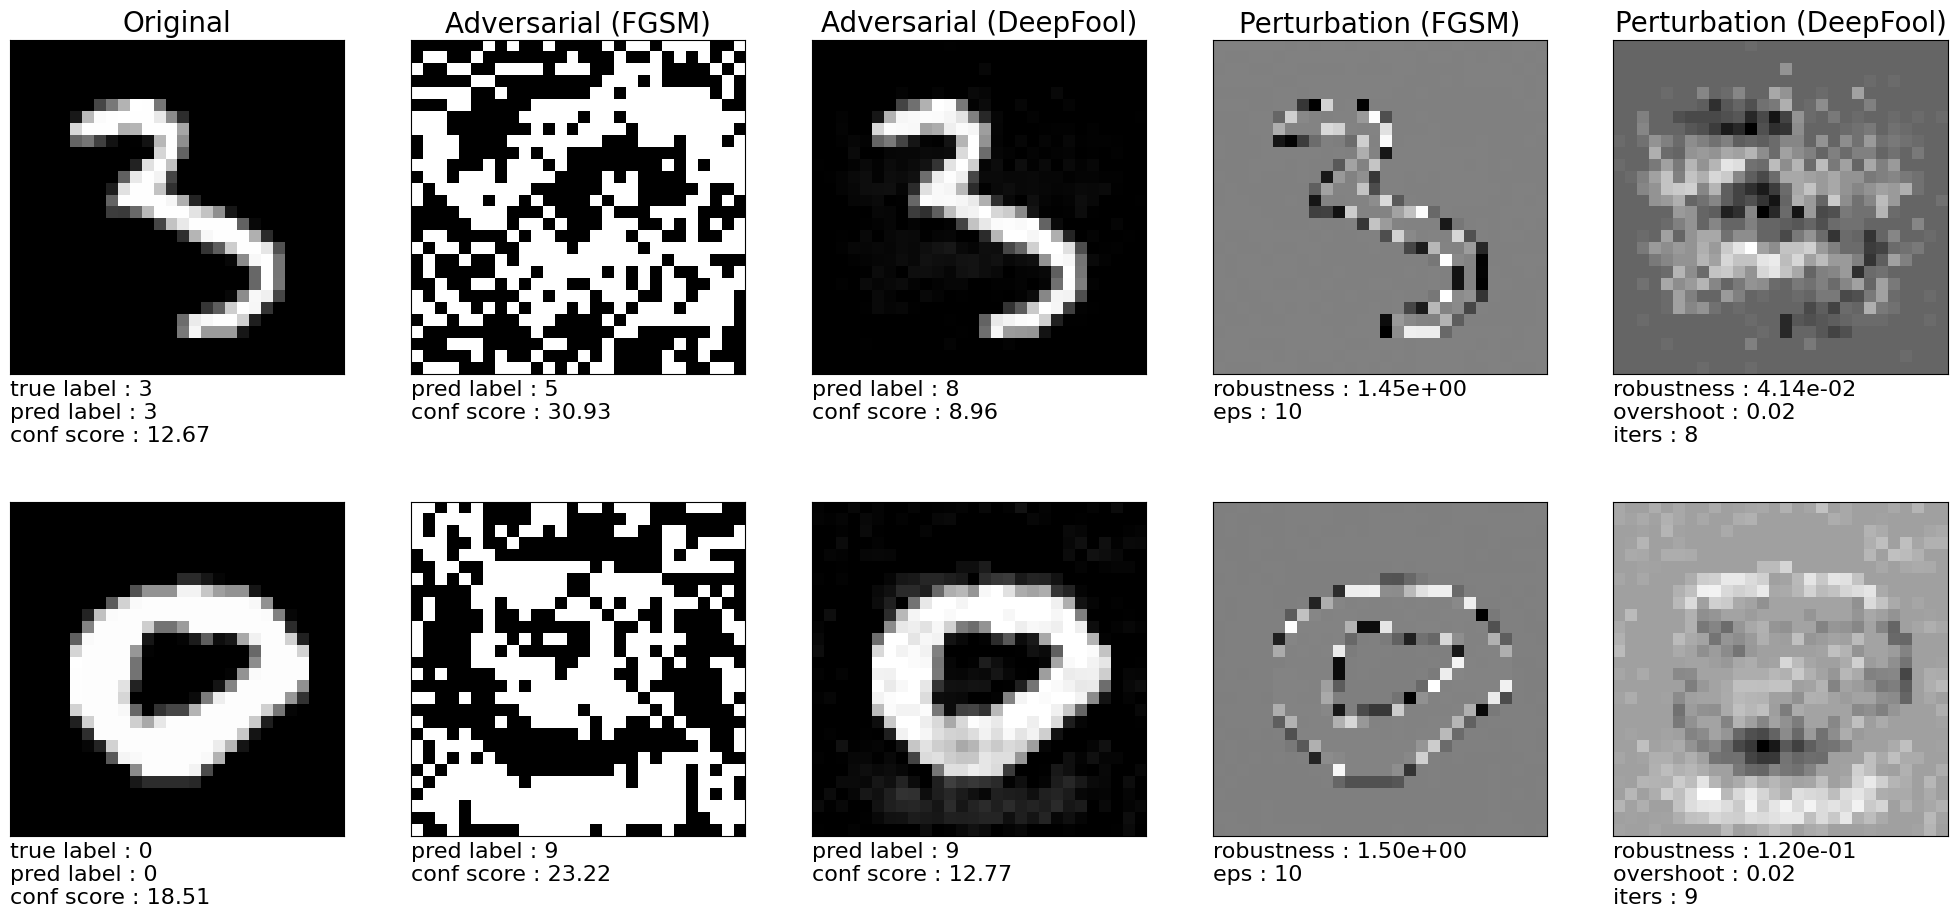

In [ ]:
#FCNet
model = FC_500_150().to(device)
model.load_state_dict(torch.load('weights/clean/mnist_fc.pth'))

for fgsm_eps in [0.001, 0.02, 0.5, 0.9, 10]:
  print(f"Величина fsgsm_eps = {fgsm_eps}:")
  mnist_fc_fgsm = 'mnist_fc_fgsm' + str(fgsm_eps) + '.csv'
  evaluate_attack(mnist_fc_fgsm, 'results', device, model, mnist_loader_test, mnist_min, mnist_max, fgsm_eps, is_fgsm=True)
  display_attack(device, model, mnist_test, mnist_tf_inv, mnist_min, mnist_max, fgsm_eps, deep_args, has_labels=False, l2_norm=True, pert_scale=1.0, fig_rows=2, fig_width=25, fig_height=11)
  if device.type == 'cuda': torch.cuda.empty_cache()
  print('')